In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import utils

In [2]:
# Read csv
vgs = pd.read_csv("../data/vgs.csv")
vgs = vgs.iloc[::-1] #csv is in reverse chronological order; this line inverts it
vgs['Date'] = pd.to_datetime(vgs['Date'], format='%d/%m/%Y') #convert dates from str to datetime object
vgs['Vol.'] = vgs['Vol.'].str.replace('K','') #this is formatted like 100.00K in the csv
vgs['Change %'] = vgs['Change %'].str.replace('%','')
vgs = vgs.astype({'Vol.':float, 'Change %':float}) #specify value types

# Extract information from the dataframe
date = vgs['Date'].to_numpy()
open_price = vgs['Open'].to_numpy()
close_price = vgs['Price'].to_numpy()
max_price = vgs['High'].to_numpy()
min_price = vgs['Low'].to_numpy()
volume = vgs['Vol.'].to_numpy()*1000
change = vgs['Change %'].to_numpy()
fluctuation = max_price - min_price
fluctuation_end = close_price - open_price
fluctuation_ratio = abs(fluctuation_end[fluctuation!=0])/fluctuation[fluctuation!=0]

# to use as legend label in some histograms
daterange = f"{str(date[0])[:10]} to {str(date[-1])[:10]}"

# Plots

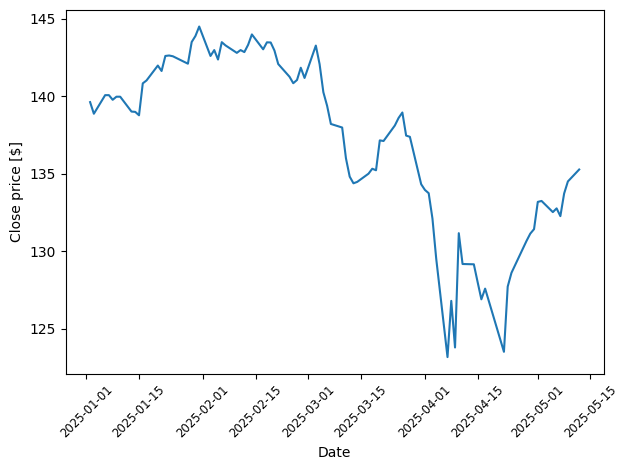

In [3]:
# Closing price (time series)
utils.plot_line(date, close_price, xlabel="Date", ylabel="Close price [$]")
utils.save("price", show=True)

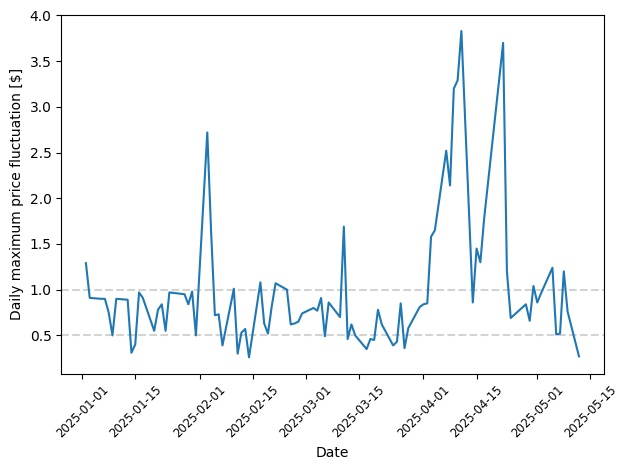

In [4]:
# Daily maximum fluctuation (time series)
utils.plot_line(date, fluctuation, xlabel="Date", ylabel="Daily maximum price fluctuation [$]", horizontal=[0.5,1])
utils.save("day_range", show=True)

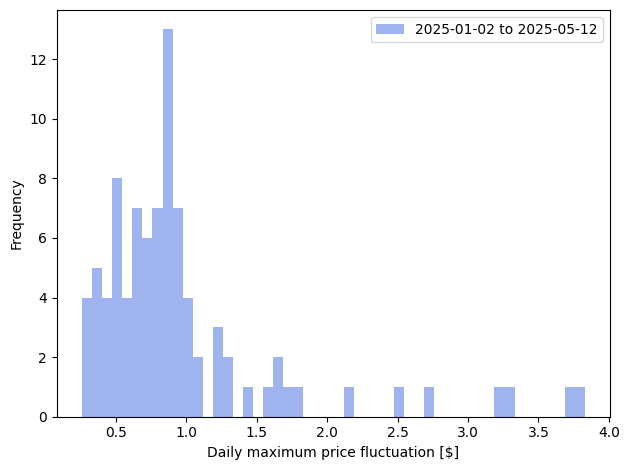

In [5]:
# Daily maximum fluctuation (histogram)
utils.plot_hist(fluctuation, xlabel="Daily maximum price fluctuation [$]", legend=daterange)
plt.legend()
utils.save("day_range_binned", show=True)

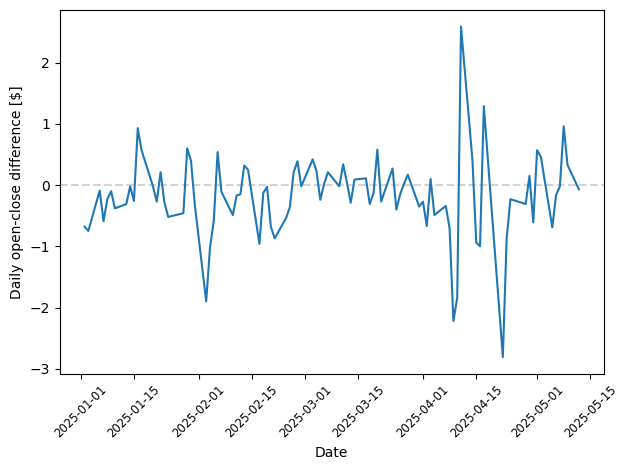

In [6]:
# Daily open minus close (time series)
utils.plot_line(date, fluctuation_end, xlabel="Date", ylabel="Daily open-close difference [$]", horizontal=[0])
utils.save("open_close_difference", show=True)

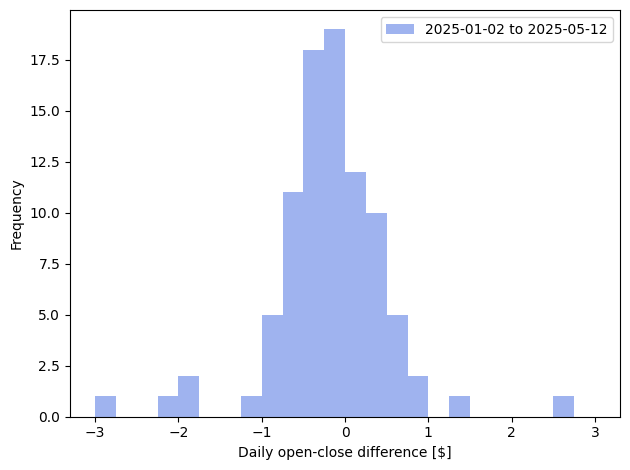

In [7]:
# Daily open minus close (histogram)
utils.plot_hist(fluctuation_end, axisrange=(-3,3), nbins=24, xlabel="Daily open-close difference [$]", legend=daterange)
plt.legend()
utils.save("open_close_difference_binned", show=True)

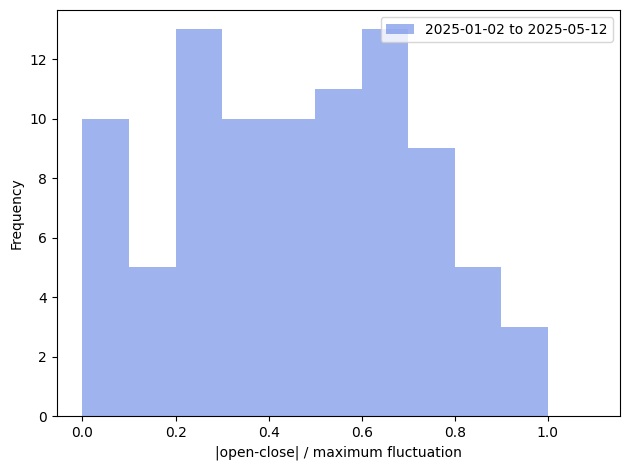

In [8]:
# Ratio of daily end-to-end fluctuation to the maximum fluctuation
utils.plot_hist(fluctuation_ratio, axisrange=(0,1.1), nbins=11, xlabel="|open-close| / maximum fluctuation", legend=daterange)
plt.legend()
utils.save("fluctuation_ratio", show=True)

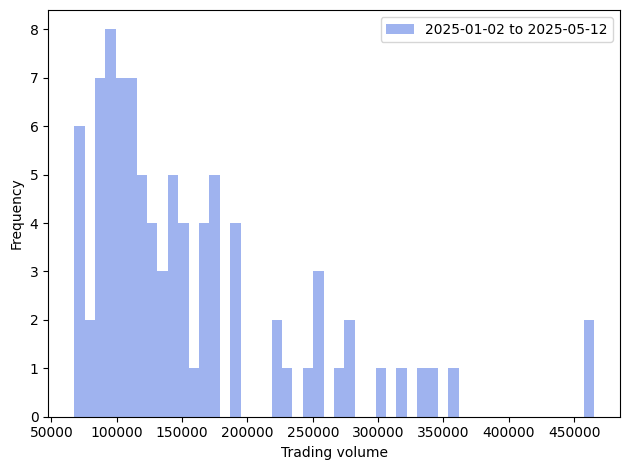

In [9]:
# Trading volume
utils.plot_hist(volume, xlabel="Trading volume", legend=daterange)
plt.legend()
utils.save("volume", show=True)

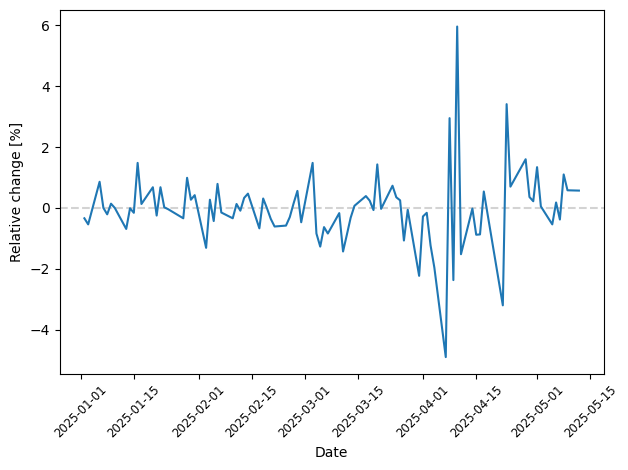

In [10]:
# Daily relative change
utils.plot_line(date, change, xlabel="Date", ylabel="Relative change [%]", horizontal=[0])
utils.save("change", show=True)

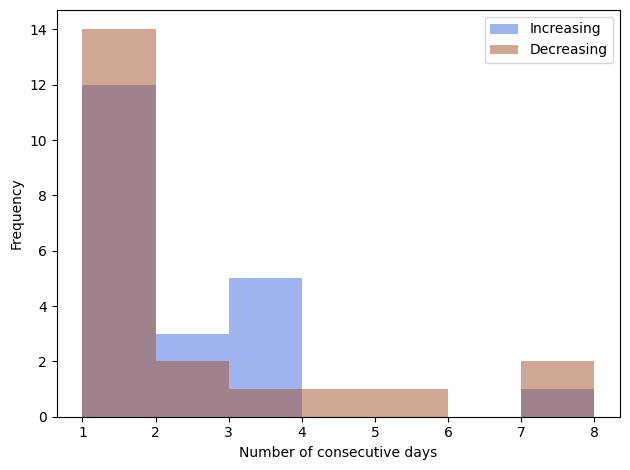

In [11]:
# Number of consecutive days that the unit price increased or decreased
numberConsecutiveIncreasing = []
numberConsecutiveDecreasing = []
countIncreasing = True #will flip to False when counting consecutive decreasing days
count = 0
for i in range(1,len(close_price)):
    if close_price[i] > close_price[i-1]:
        # if we were counting consecutive decreasing days, append to the list and reset the count
        if count > 0 and not countIncreasing:
            numberConsecutiveDecreasing.append(count)
            count = 0

        # start counting consecutive increasing days
        countIncreasing = True
        count += 1
    elif close_price[i] < close_price[i-1]:
        if count > 0 and countIncreasing:
            numberConsecutiveIncreasing.append(count)
            count = 0
        countIncreasing = False
        count += 1
    else:
        # in case two consecutive days close at the same value
        if count > 0:
            if countIncreasing:
                numberConsecutiveIncreasing.append(count)
            else:
                numberConsecutiveDecreasing.append(count)

        # reset count
        count = 0

    # on final iteration: append count to the corresponding list
    if i == len(close_price)-1 and count > 0:
        if countIncreasing: numberConsecutiveIncreasing.append(count)
        else: numberConsecutiveDecreasing.append(count)

xmin = min( min(numberConsecutiveIncreasing), min(numberConsecutiveDecreasing) )
xmax = max( max(numberConsecutiveIncreasing), max(numberConsecutiveDecreasing) )
nbins = xmax - xmin
utils.plot_hist(numberConsecutiveIncreasing, axisrange=(xmin,xmax), nbins=nbins, xlabel="Number of consecutive days", legend="Increasing")
utils.plot_hist(numberConsecutiveDecreasing, axisrange=(xmin,xmax), nbins=nbins, color="sienna", xlabel="", legend="Decreasing")
plt.legend()
utils.save("consecutive_days", show=True)

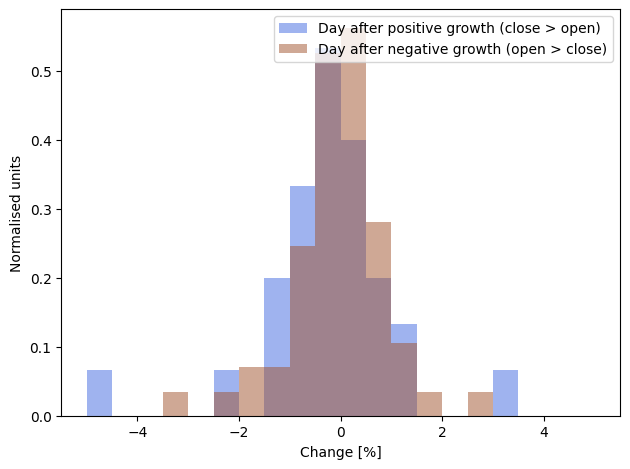

In [12]:
# For the days where open price > close price: plot the change % for the following day
following_negative_change = [ val for i,val in enumerate(change[1:]) if open_price[i-1] > close_price[i-1] ]
following_positive_change = [ val for i,val in enumerate(change[1:]) if open_price[i-1] < close_price[i-1] ]
utils.plot_hist(following_positive_change, axisrange=(-5,5), nbins=20, density=True, xlabel="Change [%]", ylabel="Normalised units", legend="Day after positive growth (close > open)")
utils.plot_hist(following_negative_change, axisrange=(-5,5), nbins=20, density=True, color="sienna", xlabel="", ylabel="", legend="Day after negative growth (open > close)")
plt.legend()
utils.save("following_day_change", show=True)